# PneumoScope: Deep Learning Model Analysis for Pneumonia Classification

## Overview
This notebook provides visualization and analysis of two trained deep learning models:

### 1. Binary Classification Model
Distinguishes between normal chest X-rays and pneumonia cases

### 2. Multiclass Classification Model
Classifies chest X-rays into:
- Normal
- Bacterial pneumonia
- Viral pneumonia

## Analyses Performed

### 1. Model Visualization
- Generated loss, precision, recall, F1 and accuracy plots 
- Produced confusion matrices for performance analysis
- Printed the models archetecture

### 3. Grad-CAM Implementation
- Implemented Grad-CAM visualization for model interpretability
- Analyzed correct and incorrect predictions
- Visualized model attention areas on chest X-rays
- Displayed prediction probabilities for each class

## Testdataset Statistics
- Normal images: 234
- Pneumonia images: 390
    - Virus pneumonia images: 148
    - Bacterial pneumonia images: 242
- **Total images: 624**

## Technical Details
The notebook uses PyTorch for deep learning operations and includes various visualization techniques to understand model behavior and performance.

In [1]:
# Standard library imports
import json
import os
import random
import shutil
import sys
from typing import Dict, Tuple

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown

# PyTorch related imports
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary

In [2]:
# Add parent directory to Python path
sys.path.append("C:/Users/glajusj/Documents/github/PneumoScope") #Change to your own path

# Import PneumoNet from model.py
from src.model import PneumoNet
from src.train_multiclass import PneumoNetMulti

## Load training logs

#### Binary model logs

In [3]:

# Load the JSON file
file_path = "../results/training_logs_e19_b32_20250113-012235.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert lists to DataFrame for plotting
df_binary = pd.DataFrame(data)
df_binary.head()

train_loss  train_precision  train_recall  train_f1  train_accuracy  \
0    0.244615         0.908787      0.914025  0.911398        0.909800   
1    0.157649         0.940117      0.947963  0.944023        0.944174   
2    0.169328         0.938139      0.936315  0.937226        0.937104   
3    0.148164         0.948555      0.945312  0.946931        0.947099   
4    0.143478         0.945232      0.941091  0.943157        0.943198   

   train_auc      train_confusion_matrix  val_loss  val_precision  val_recall  \
0   0.964099  [[1829, 191], [179, 1903]]  0.099188       0.988782    0.964063   
1   0.983936  [[1942, 123], [106, 1931]]  0.126130       0.955927    0.982812   
2   0.982849  [[1918, 127], [131, 1926]]  0.082794       0.982759    0.979688   
3   0.985789  [[1949, 105], [112, 1936]]  0.113993       0.988710    0.957812   
4   0.987284  [[1936, 112], [121, 1933]]  0.089013       0.985669    0.967187   

     val_f1  val_accuracy   val_auc    val_confusion_matrix  
0  0.976266      0.965792  0.992880   [[230, 7], [23, 617]]  
1  0.969183      0.954390  0.988601  [[208, 29], [11, 629]]  
2  0.981221      0.972634  0.994858  [[226, 11], [13, 627]]  
3  0.973016      0.961231  0.993394   [[230, 7], [27, 613]]  
4  0.976341      0.965792  0.994627   [[228, 9], [21, 619]]

#### Multi model logs

In [4]:
# Load the JSON file
file_path = "../results/multiclass/training_logs_multi_e22_20250113-081655.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert lists to DataFrame for plotting
df_multi = pd.DataFrame(data)
df_multi.head()

train_loss  train_precision  train_recall  train_f1  train_accuracy  \
0    0.640701         0.716760      0.709570  0.710067        0.731838   
1    0.545663         0.761028      0.746075  0.749890        0.771575   
2    0.534259         0.775589      0.764548  0.766913        0.785471   
3    0.498404         0.774293      0.766560  0.768290        0.785714   
4    0.484380         0.788028      0.778907  0.782210        0.795466   

                              train_confusion_matrix  val_loss  val_precision  \
0  [[1557, 102, 287], [88, 965, 56], [475, 92, 480]]  1.332567       0.711203   
1   [[1658, 51, 237], [47, 995, 67], [465, 70, 512]]  0.836550       0.723342   
2  [[1653, 61, 232], [41, 1018, 50], [425, 71, 551]]  0.641017       0.766132   
3  [[1641, 53, 252], [31, 1022, 56], [416, 71, 560]]  0.895817       0.759145   
4  [[1644, 43, 259], [37, 1019, 53], [394, 53, 600]]  0.475540       0.797450   

   val_recall    val_f1  val_accuracy  \
0    0.468474  0.394569      0.497149   
1    0.669631  0.617326      0.717218   
2    0.707244  0.725892      0.743444   
3    0.680496  0.636122      0.734322   
4    0.784864  0.790564      0.800456   

                          val_confusion_matrix  
0   [[263, 0, 154], [0, 4, 233], [54, 0, 169]]  
1  [[359, 47, 11], [0, 237, 0], [123, 67, 33]]  
2  [[364, 0, 53], [44, 161, 32], [91, 5, 127]]  
3   [[376, 33, 8], [3, 234, 0], [143, 46, 34]]  
4   [[353, 4, 60], [4, 215, 18], [84, 5, 134]]

## Plots of Loss Binary and Multi Model

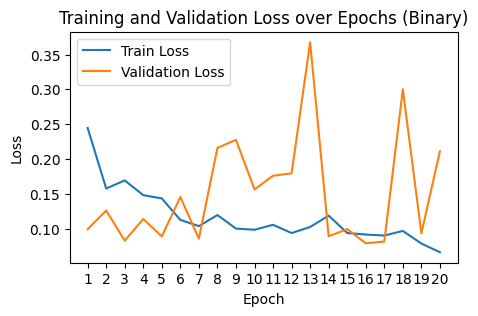

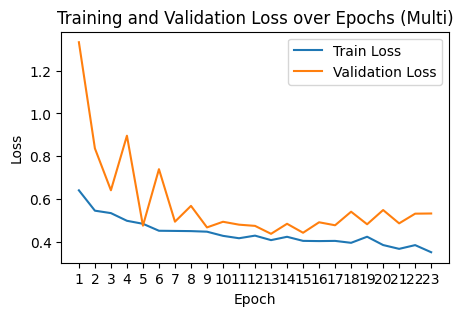

In [5]:
def plot_training_loss(df, model_type):
    """
    Plot training and validation loss over epochs.
    
    Args:
        df: DataFrame containing 'train_loss' and 'val_loss' columns
        model_type: String indicating model type ('Binary' or 'Multi')
    """
    # Create figure
    plt.figure(figsize=(5, 3))
    
    # Get number of epochs
    num_epochs = len(df)
    
    # Plot losses
    plt.plot(range(1, num_epochs + 1), df['train_loss'], label='Train Loss')
    plt.plot(range(1, num_epochs + 1), df['val_loss'], label='Validation Loss')
    
    # Customize plot
    plt.xlabel('Epoch')
    plt.xticks(np.arange(1, num_epochs + 1, step=1))
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss over Epochs ({model_type})')
    plt.legend()
    
    # Display plot
    plt.show()

# Usage for binary model
plot_training_loss(df_binary, 'Binary')

# Usage for multiclass model
plot_training_loss(df_multi, 'Multi')



## Plots of Precision, Recall, F1, AUC and Accuracy
### Binary and Multi

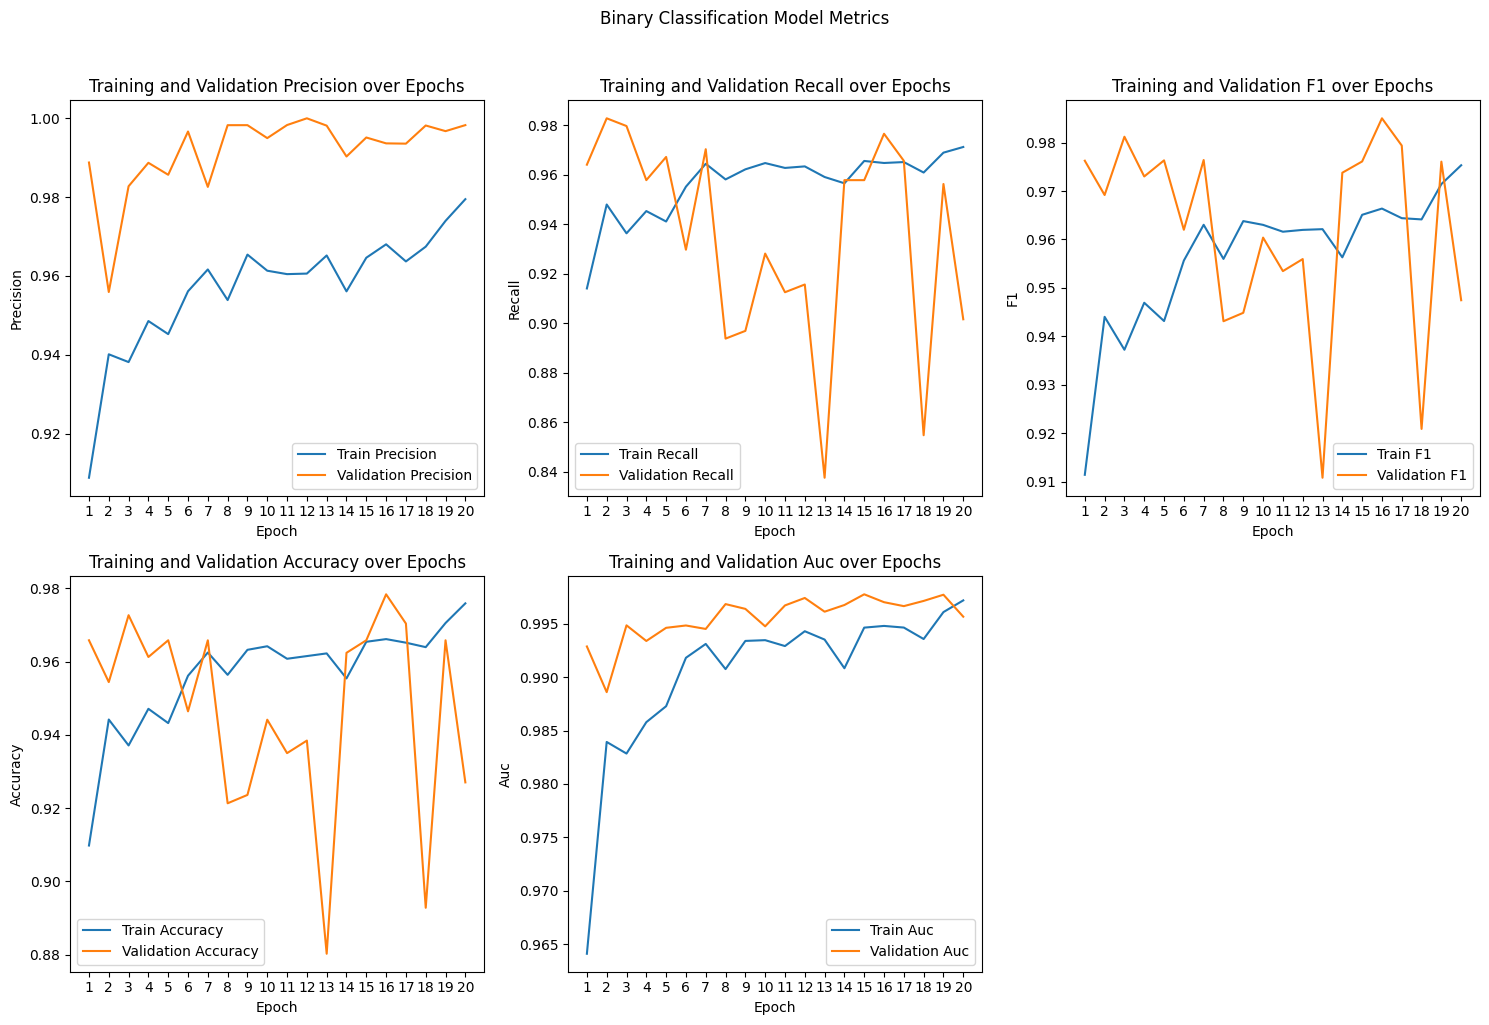

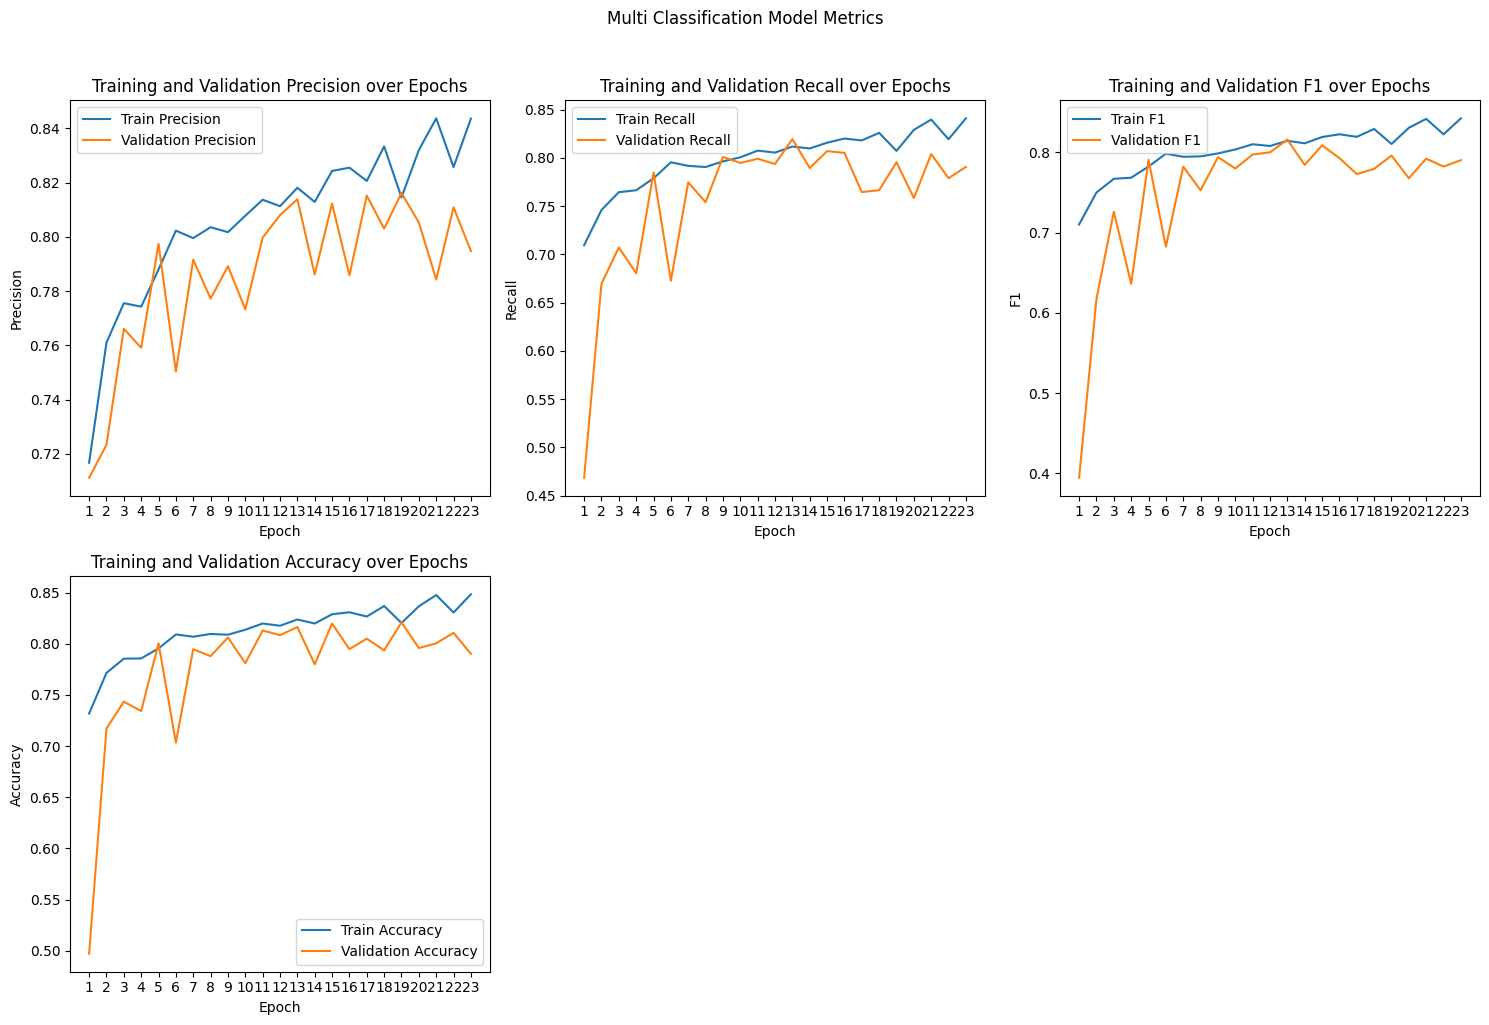

In [6]:
def plot_metrics_grid(df, model_type, metrics=None):
    """
    Plot training and validation metrics in a grid layout.
    
    Args:
        df: DataFrame containing training and validation metrics
        model_type: String indicating model type ('Binary' or 'Multi')
        metrics: List of metrics to plot. If None, defaults to standard metrics
    """
    # Define default metrics if none provided
    if metrics is None:
        metrics = ['precision', 'recall', 'f1', 'accuracy', 'auc'] if model_type == 'Binary' else ['precision', 'recall', 'f1', 'accuracy']
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Get number of epochs
    num_epochs = len(df)
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        # Determine subplot position
        row, col = divmod(i, 3)
        ax = axes[row, col]
        
        # Plot training and validation curves
        ax.plot(range(1, num_epochs + 1), df[f'train_{metric}'], 
                label=f'Train {metric.capitalize()}')
        ax.plot(range(1, num_epochs + 1), df[f'val_{metric}'], 
                label=f'Validation {metric.capitalize()}')
        
        # Customize subplot
        ax.set_xlabel('Epoch')
        ax.set_xticks(np.arange(1, num_epochs + 1))
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training and Validation {metric.capitalize()} over Epochs')
        ax.legend()
    
    # Hide empty subplots
    if len(metrics) < 6:
        for i in range(len(metrics), 6):
            row, col = divmod(i, 3)
            fig.delaxes(axes[row, col])
    
    # Adjust layout and display
    plt.suptitle(f'{model_type} Classification Model Metrics', y=1.02)
    plt.tight_layout()
    plt.show()

# Usage for binary model
plot_metrics_grid(df_binary, 'Binary')

# Usage for multiclass model
plot_metrics_grid(df_multi, 'Multi')


## Confusion matrices Binary and Multi

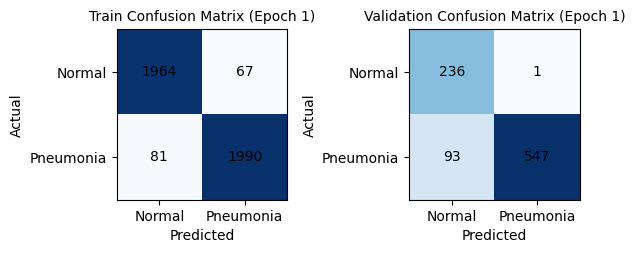

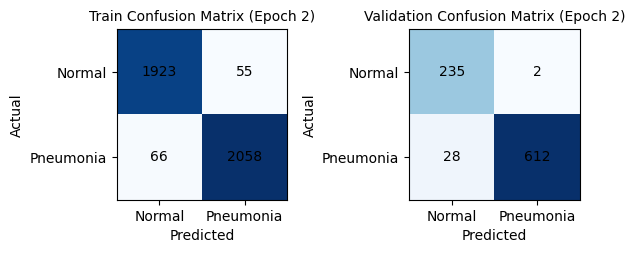

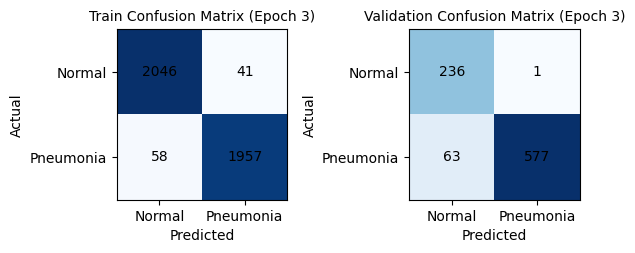

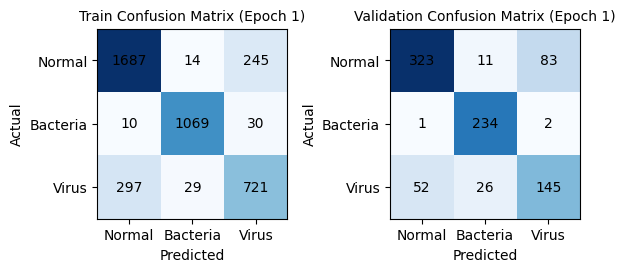

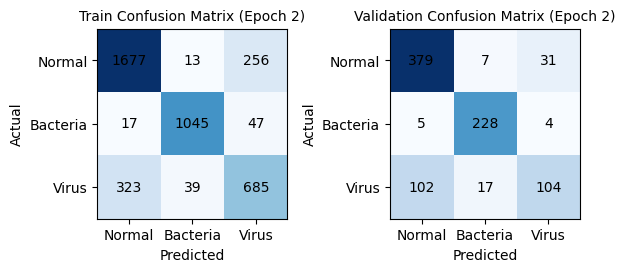

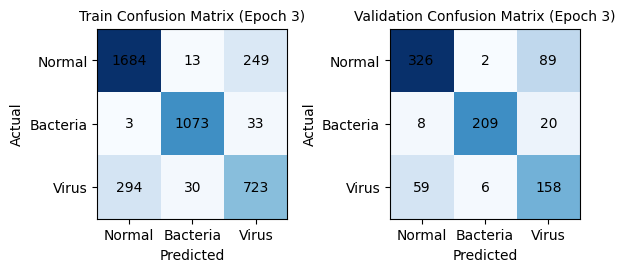

In [7]:
def plot_confusion_matrices_for_model(df, model_type='binary', n_epochs=3):
    """
    Plot confusion matrices for the last n epochs of training.
    
    Args:
        df: DataFrame containing confusion matrix data
        model_type: String indicating 'binary' or 'multi' classification
        n_epochs: Number of last epochs to plot (default: 3)
    """
    # Define class names based on model type
    class_names = {
        'binary': ["Normal", "Pneumonia"],
        'multi': ["Normal", "Bacteria", "Virus"]
    }[model_type.lower()]
    
    # Extract confusion matrices from the last n epochs
    train_conf_matrices = df['train_confusion_matrix'][-n_epochs:]
    val_conf_matrices = df['val_confusion_matrix'][-n_epochs:]
    
    def plot_epoch_matrices(train_cm, val_cm, epoch):
        """Helper function to plot confusion matrices for a single epoch."""
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        
        # Common parameters for both plots
        n_classes = len(class_names)
        plot_params = {
            'xticks': range(n_classes),
            'yticks': range(n_classes),
            'xticklabels': class_names,
            'yticklabels': class_names
        }
        
        # Plot and annotate matrices
        for idx, (matrix, title) in enumerate([
            (train_cm, 'Train Confusion Matrix'),
            (val_cm, 'Validation Confusion Matrix')
        ]):
            ax = axes[idx]
            
            # Plot matrix
            ax.imshow(matrix, cmap='Blues')
            ax.set_title(f'{title} (Epoch {epoch})', fontsize=10)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            
            # Set axis labels
            ax.set_xticks(plot_params['xticks'])
            ax.set_yticks(plot_params['yticks'])
            ax.set_xticklabels(plot_params['xticklabels'])
            ax.set_yticklabels(plot_params['yticklabels'])
            
            # Add value annotations
            for (i, j), val in np.ndenumerate(matrix):
                ax.text(j, i, f'{val}', ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
    
    # Plot matrices for each epoch
    for i, (train_cm, val_cm) in enumerate(zip(train_conf_matrices, val_conf_matrices), 1):
        plot_epoch_matrices(
            np.array(train_cm),
            np.array(val_cm),
            epoch=i
        )

# Usage examples:
# For binary classification
plot_confusion_matrices_for_model(df_binary, model_type='binary')

# For multiclass classification
plot_confusion_matrices_for_model(df_multi, model_type='multi')


## Model summary Binary

In [8]:
# Load the checkpoint
checkpoint_path = "../saved_models/best_binary_model_20250113-012235.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Initialize the model with num_classes=1 for binary classification
model_binary = PneumoNet(num_classes=1)
model_binary.load_state_dict(checkpoint['model_state_dict'])
model_binary.eval()  # Set to evaluation mode


# Capture summary output
def capture_summary(model):
    from io import StringIO
    import sys

    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    
    summary(model, input_size=(3, 224, 224))
    
    sys.stdout = old_stdout
    return mystdout.getvalue()

# Get model summary as string
summary_output = capture_summary(model_binary)

# Display as markdown
display(Markdown(f"```plaintext\n{summary_output}\n```"))


C:\Users\glajusj\AppData\Local\Temp\ipykernel_10932\277590997.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch

```plaintext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                    [-1, 1]             513
           ResNet-69                    [-1, 1]               0
================================================================
Total params: 11,177,025
Trainable params: 11,177,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 62.79
Params size (MB): 42.64
Estimated Total Size (MB): 106.00
----------------------------------------------------------------

```

## Model summary Multi

In [9]:
# Load the checkpoint for the multiclass model
checkpoint_path = "../saved_models/best_multi_model_20250113-081655.pth"  # Update with correct checkpoint path
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Initialize the model for multiclass classification (3 classes)
model_multi = PneumoNetMulti(use_pretrained=False)
model_multi.load_state_dict(checkpoint['model_state_dict'])
model_multi.eval()  # Set to evaluation mode

# Capture and display summary
summary_output_str = capture_summary(model_multi)
display(Markdown(f"```plaintext\n{summary_output_str}\n```"))


C:\Users\glajusj\AppData\Local\Temp\ipykernel_10932\3909944581.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torc

```plaintext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                    [-1, 3]           1,539
           ResNet-69                    [-1, 3]               0
================================================================
Total params: 11,178,051
Trainable params: 11,178,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 62.79
Params size (MB): 42.64
Estimated Total Size (MB): 106.00
----------------------------------------------------------------

```

## Heatmap inference Binary

In [10]:
# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Collecting samples for analysis...

### Displaying correctly classified images:

c:\Users\glajusj\Documents\github\PneumoScope\.venv\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


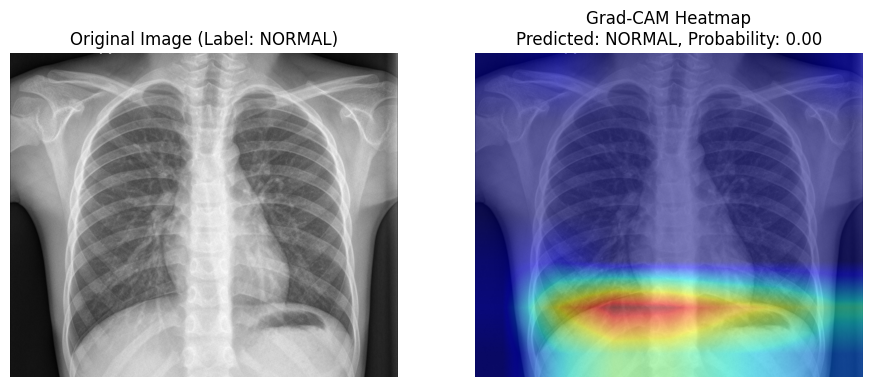

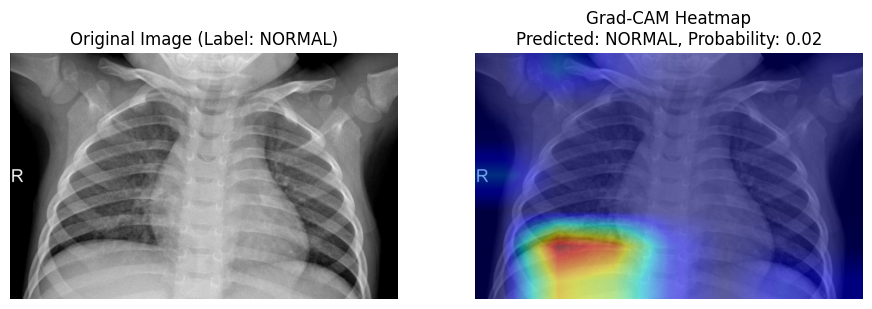

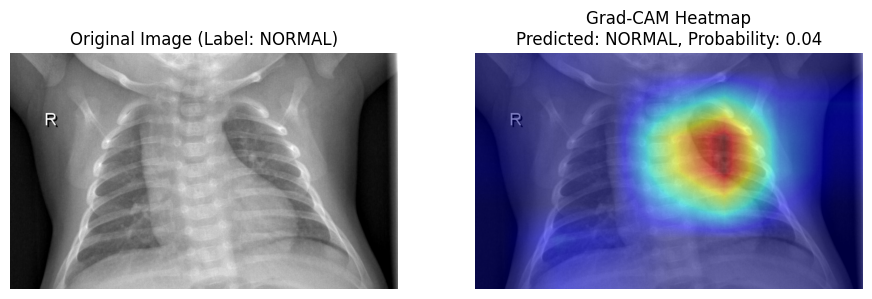

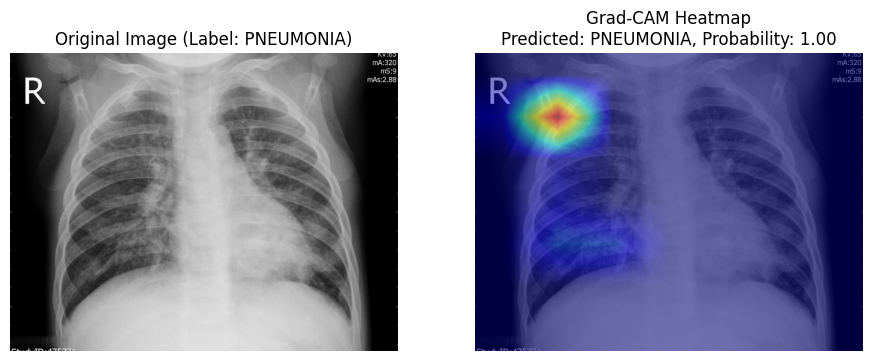

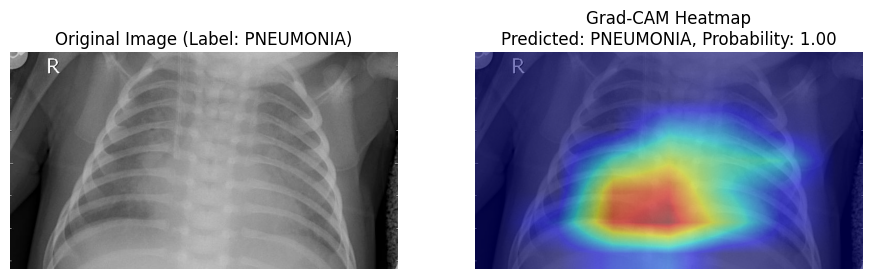

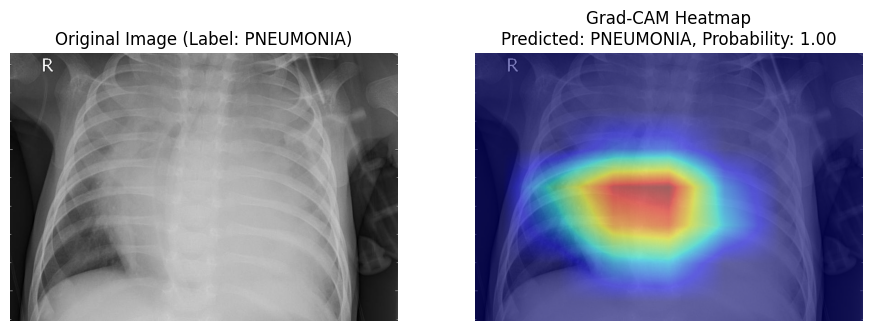

### Displaying incorrectly classified images:

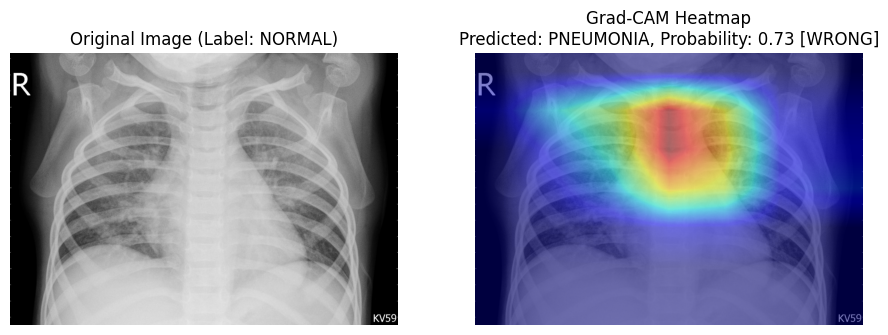

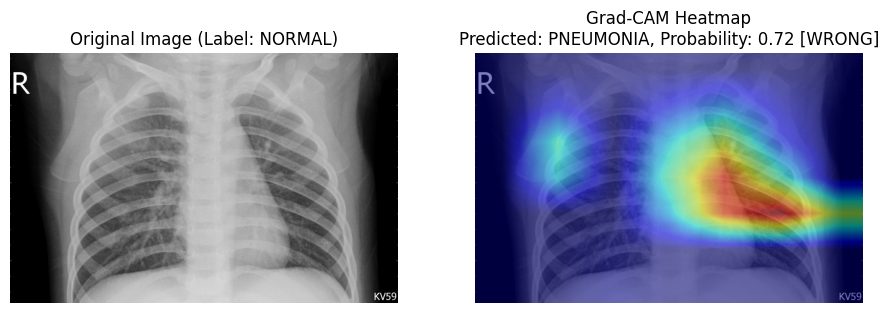

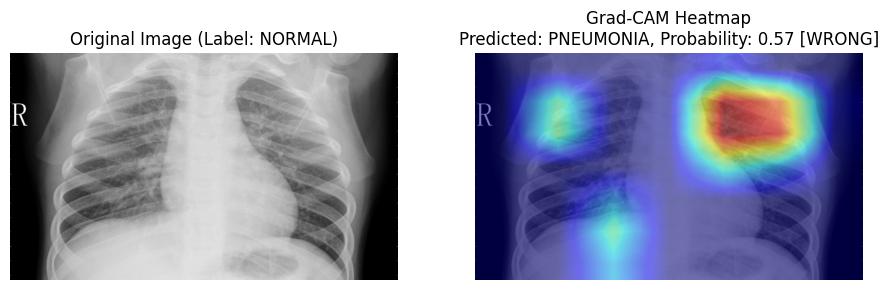

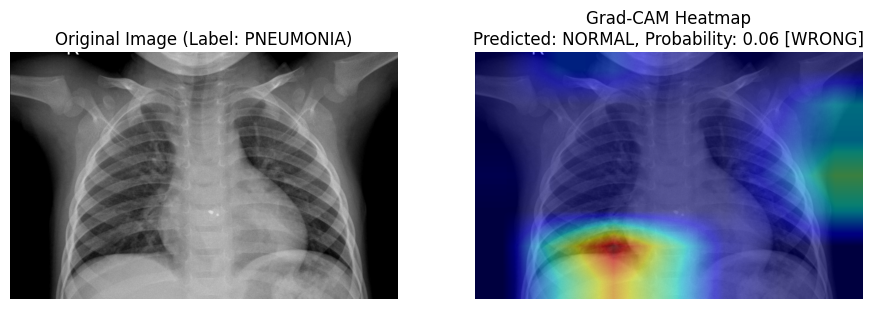

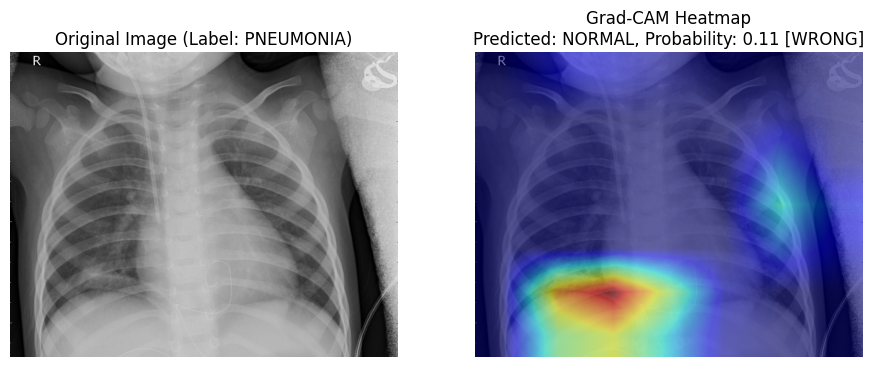

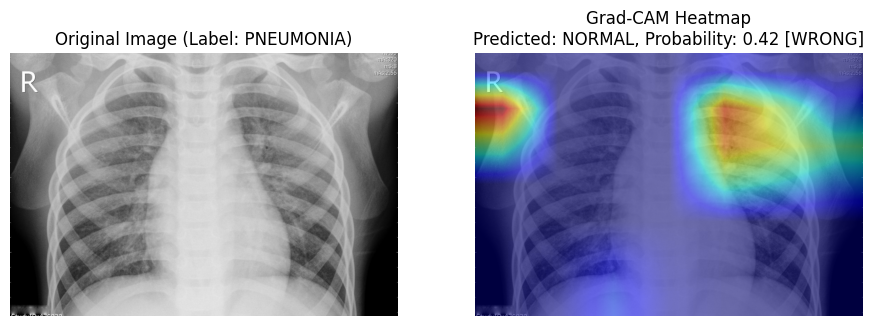

In [11]:
# Define class labels
BINARY_LABELS = {0: "NORMAL", 1: "PNEUMONIA"}
MULTI_LABELS = {0: "NORMAL", 1: "BACTERIA", 2: "VIRUS"}

# Initialize global variable for activations
activations = None

def register_hooks(model, model_type='binary'):
    """
    Register forward and backward hooks on the model.
    
    Args:
        model: The PyTorch model
        model_type: 'binary' or 'multi' for classification type
    """
    global activations
    gradients = []
    activations = None

    def forward_hook(module, input, output):
        global activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Get correct target layer based on model type
    target_layer = model.base_model.layer4[-1].conv2 if model_type == 'binary' else model.model.layer4[-1].conv2

    # Clear all existing hooks
    if hasattr(target_layer, '_backward_hooks'):
        target_layer._backward_hooks.clear()
    if hasattr(target_layer, '_forward_hooks'):
        target_layer._forward_hooks.clear()
    if hasattr(target_layer, '_forward_pre_hooks'):
        target_layer._forward_pre_hooks.clear()
    
    # Reset the hook type flag
    target_layer._is_full_backward_hook = False
    
    # Register new hooks using regular backward hook
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    return gradients

def compute_gradcam(image_path, model, transform, model_type='binary'):
    """
    Compute Grad-CAM for an image.
    
    Args:
        image_path: Path to the image file
        model: The PyTorch model
        transform: Preprocessing transforms
        model_type: 'binary' or 'multi' for classification type
    """
    global activations
    gradients = register_hooks(model, model_type)
    labels = BINARY_LABELS if model_type == 'binary' else MULTI_LABELS

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    # Forward pass
    output = model(input_tensor)
    
    if model_type == 'binary':
        probability = torch.sigmoid(output).item()
        predicted_class = 1 if probability >= 0.5 else 0
    else:
        probabilities = torch.softmax(output, dim=1).squeeze()
        predicted_class = probabilities.argmax().item()
        probability = probabilities[predicted_class].item()

    # Backward pass
    model.zero_grad()
    if model_type == 'binary':
        output.backward()
    else:
        output[0, predicted_class].backward()

    # Get gradients and activations
    grad = gradients[0].cpu().numpy()
    act = activations.detach().cpu().numpy()[0]

    # Compute weighted combination of activation maps
    weights = np.mean(grad, axis=(1, 2))
    gradcam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        gradcam += w * act[i]

    # Process heatmap
    gradcam = np.maximum(gradcam, 0)
    gradcam = gradcam / gradcam.max()
    gradcam = Image.fromarray(np.uint8(255 * gradcam)).resize(image.size, Image.BILINEAR)
    
    return image, np.array(gradcam), predicted_class, probability, labels

def visualize_gradcam(image_path, model, transform, true_label, model_type='binary', correct_prediction=None):
    """
    Visualize Grad-CAM results for an image.
    
    Args:
        image_path: Path to the image file
        model: The PyTorch model
        transform: Preprocessing transforms
        true_label: True class label
        model_type: 'binary' or 'multi' for classification type
        correct_prediction: Boolean indicating if prediction was correct
    """
    # Compute Grad-CAM
    image, gradcam, predicted_class, probability, labels = compute_gradcam(
        image_path, model, transform, model_type
    )
    
    # Create colored heatmap
    heatmap_colored = plt.cm.jet(gradcam / 255.0)[:, :, :3]
    heatmap_colored = np.uint8(255 * heatmap_colored)
    overlay = np.uint8(np.array(image) * 0.5 + heatmap_colored * 0.5)

    # Create visualization
    plt.figure(figsize=(11, 5.5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {labels[true_label]})")
    plt.imshow(image)
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 2, 2)
    title = f"Grad-CAM Heatmap\nPredicted: {labels[predicted_class]}, Probability: {probability:.2f}"
    if correct_prediction is not None and not correct_prediction:
        title += " [WRONG]"
    plt.title(title)
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()

def collect_samples(model, transform, model_type='binary', samples_per_class=3):
    """
    Collect correctly and incorrectly classified image samples from each class.
    
    Args:
        model: The PyTorch model
        transform: Preprocessing transforms
        model_type: 'binary' or 'multi' for classification type
        samples_per_class: Number of samples to collect from each class
    """
    base_dir = "../data/test"
    
    # Initialize dictionaries based on model type
    if model_type == 'binary':
        correct_images = {0: [], 1: []}
        incorrect_images = {0: [], 1: []}
        dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: os.path.join(base_dir, "PNEUMONIA")
        }
    else:
        correct_images = {0: [], 1: [], 2: []}  # Added class 2 for virus
        incorrect_images = {0: [], 1: [], 2: []}
        dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: os.path.join(base_dir, "PNEUMONIA/BACTERIA"),
            2: os.path.join(base_dir, "PNEUMONIA/VIRUS")
        }

    # Process each directory until we have enough samples from each class
    for label, directory in dirs.items():
        all_images = os.listdir(directory)
        random.shuffle(all_images)
        
        for img_name in all_images:
            image_path = os.path.join(directory, img_name)
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0)

            with torch.no_grad():
                output = model(input_tensor)
                if model_type == 'binary':
                    predicted_class = 1 if torch.sigmoid(output).item() >= 0.5 else 0
                else:
                    predicted_class = torch.softmax(output, dim=1).squeeze().argmax().item()

            if predicted_class == label:
                if len(correct_images[label]) < samples_per_class:
                    correct_images[label].append((image_path, label))
            else:
                if len(incorrect_images[label]) < samples_per_class:
                    incorrect_images[label].append((image_path, label))

            # Check if we have enough samples from this class
            if (len(correct_images[label]) >= samples_per_class and 
                len(incorrect_images[label]) >= samples_per_class):
                break

    # Combine samples from all classes
    final_correct = []
    final_incorrect = []
    for label in range(len(dirs)):  # Use range instead of hardcoded values
        final_correct.extend(correct_images[label])
        final_incorrect.extend(incorrect_images[label])

    return final_correct, final_incorrect


# Example usage in notebook
def analyze_model(model, transform, model_type='binary'):
    """
    Analyze model predictions and generate Grad-CAM visualizations.
    
    Args:
        model: The PyTorch model
        transform: Preprocessing transforms
        model_type: 'binary' or 'multi' for classification type
    """
    display(Markdown("### Collecting samples for analysis..."))
    correct_images, incorrect_images = collect_samples(model, transform, model_type)
    
    display(Markdown("### Displaying correctly classified images:"))
    for image_path, label in correct_images:
        visualize_gradcam(image_path, model, transform, label, model_type, True)
        
    display(Markdown("### Displaying incorrectly classified images:"))
    for image_path, label in incorrect_images:
        visualize_gradcam(image_path, model, transform, label, model_type, False)

# For binary classification
analyze_model(model_binary, transform, 'binary')

# Usage for multiclass classification
# analyze_model(model_multi, transform, 'multi')

## Heatmap inference Multi model

### Data preparation

In [12]:
# Function to split pneumonia files by type
def split_virus_bacteria_files(base_dir):
    """
    Splits files into 'virus' and 'bacteria' directories based on their labels in filenames.
    Displays progress using notebook-friendly output.
    
    Args:
        base_dir (str): Path to the PNEUMONIA directory
    """
    # Define output directories
    virus_dir = os.path.join(base_dir, "VIRUS")
    bacteria_dir = os.path.join(base_dir, "BACTERIA")

    # Create directories if they don't exist
    os.makedirs(virus_dir, exist_ok=True)
    os.makedirs(bacteria_dir, exist_ok=True)

    # Initialize counters
    counts = {'virus': 0, 'bacteria': 0, 'skipped': 0}

    # Iterate through files in the base directory
    for filename in os.listdir(base_dir):
        file_path = os.path.join(base_dir, filename)

        # Skip if not a file or already in a subdirectory
        if not os.path.isfile(file_path):
            continue

        # Move files based on their labels
        filename_lower = filename.lower()
        if "virus" in filename_lower:
            shutil.move(file_path, os.path.join(virus_dir, filename))
            counts['virus'] += 1
        elif "bacteria" in filename_lower:
            shutil.move(file_path, os.path.join(bacteria_dir, filename))
            counts['bacteria'] += 1
        else:
            counts['skipped'] += 1

    # Display results using Markdown for better notebook formatting
    display(Markdown("""
    ### File Splitting Complete
    - Virus images: {}
    - Bacteria images: {}
    - Skipped files: {}
    """.format(counts['virus'], counts['bacteria'], counts['skipped'])))

    return virus_dir, bacteria_dir

# Function to verify directory structure and count files
def verify_directory_structure(base_dir):
    """
    Verifies the dataset directory structure and returns file counts.
    
    Args:
        base_dir (str): Base directory containing the dataset
    
    Returns:
        Dict[str, int]: Count of files in each category
    """
    pneumonia_dir = os.path.join(base_dir, "PNEUMONIA")
    normal_dir = os.path.join(base_dir, "NORMAL")
    
    file_counts = {
        'normal': 0,
        'virus': 0,
        'bacteria': 0
    }

    # Count normal images
    if os.path.exists(normal_dir):
        file_counts['normal'] = len([f for f in os.listdir(normal_dir) 
                                   if os.path.isfile(os.path.join(normal_dir, f))])

    # Count pneumonia images by type
    virus_dir = os.path.join(pneumonia_dir, "VIRUS")
    bacteria_dir = os.path.join(pneumonia_dir, "BACTERIA")

    if os.path.exists(virus_dir):
        file_counts['virus'] = len([f for f in os.listdir(virus_dir) 
                                  if os.path.isfile(os.path.join(virus_dir, f))])
    
    if os.path.exists(bacteria_dir):
        file_counts['bacteria'] = len([f for f in os.listdir(bacteria_dir) 
                                     if os.path.isfile(os.path.join(bacteria_dir, f))])

    # Display results using Markdown
    display(Markdown("""
    ### Dataset Structure Verification
    - Normal images: {}
    - Virus pneumonia images: {}
    - Bacterial pneumonia images: {}
    - Total images: {}
    """.format(
        file_counts['normal'],
        file_counts['virus'],
        file_counts['bacteria'],
        sum(file_counts.values())
    )))

    return file_counts

# Example usage in notebook
base_dir = "../data/test/PNEUMONIA"
print("Starting data preparation...")

# Split the files
virus_dir, bacteria_dir = split_virus_bacteria_files(base_dir)

# Verify the structure
file_counts = verify_directory_structure("../data/test")

Starting data preparation...



    ### File Splitting Complete
    - Virus images: 148
    - Bacteria images: 242
    - Skipped files: 0
    


    ### Dataset Structure Verification
    - Normal images: 234
    - Virus pneumonia images: 148
    - Bacterial pneumonia images: 242
    - Total images: 624
    

### Heatmap for Multi model

### Collecting samples for analysis...

### Displaying correctly classified images:

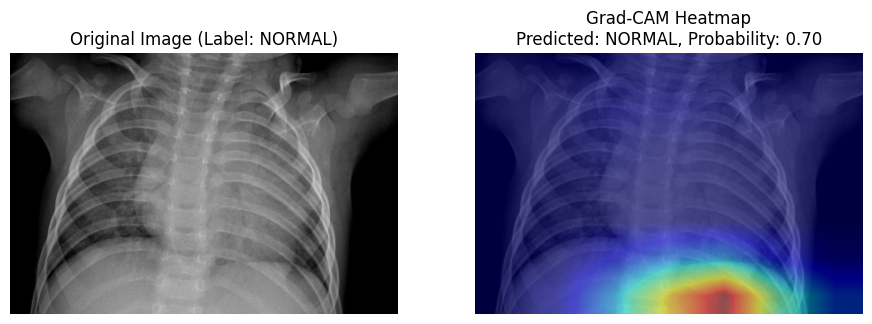

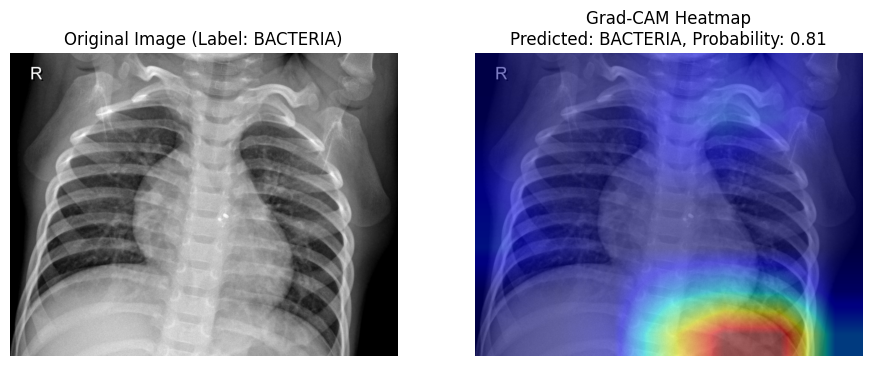

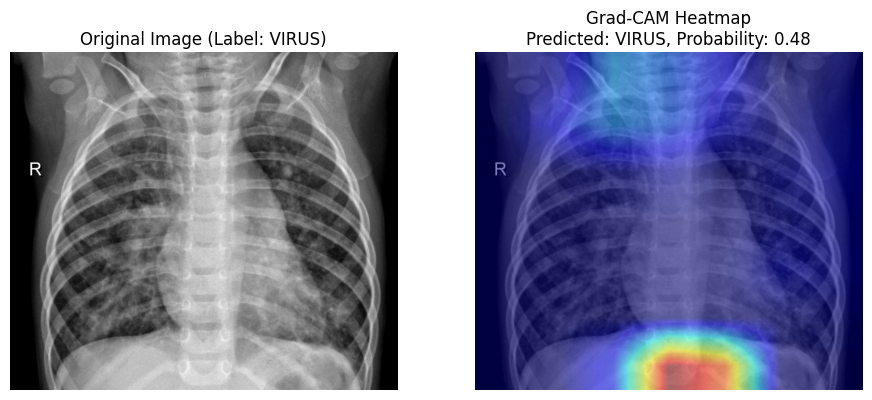

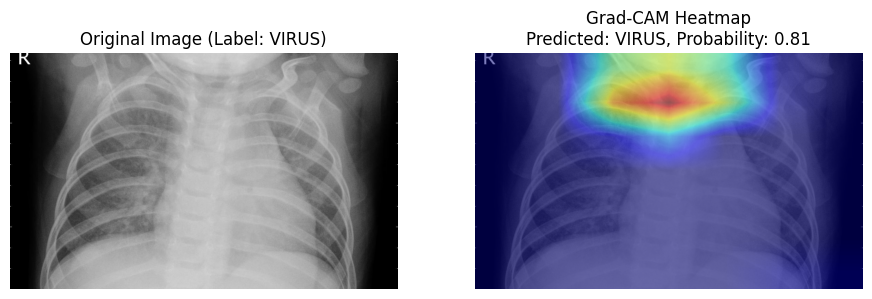

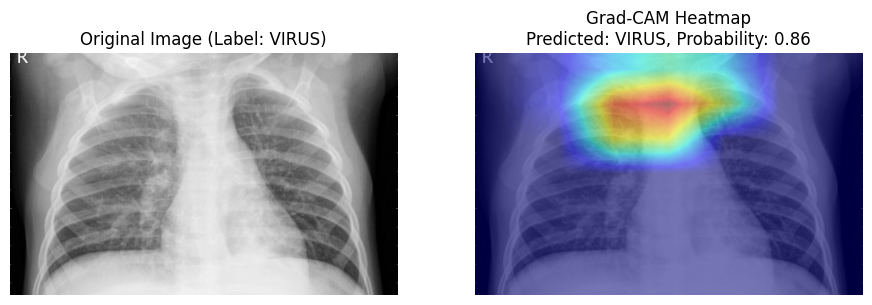

### Displaying incorrectly classified images:

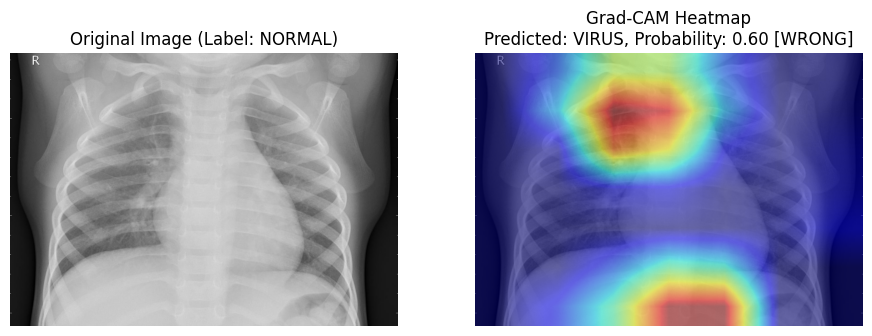

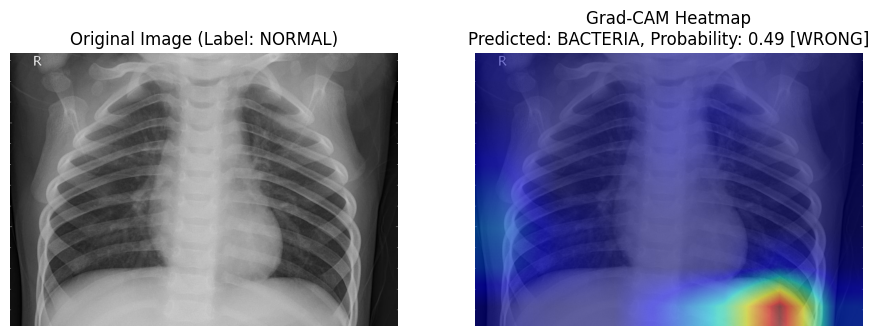

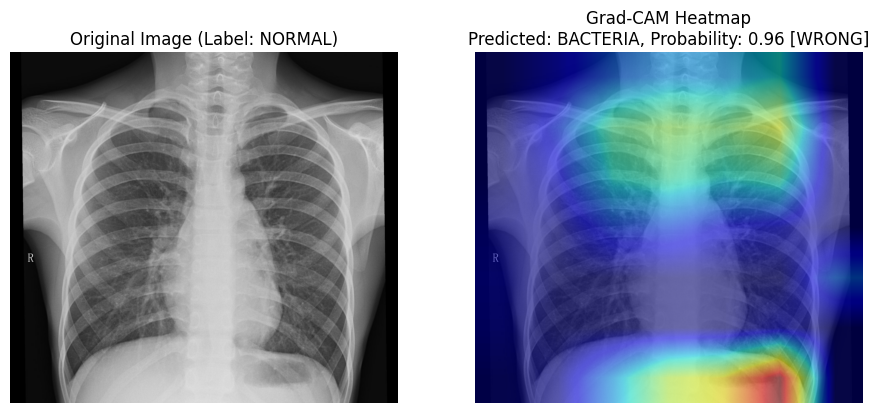

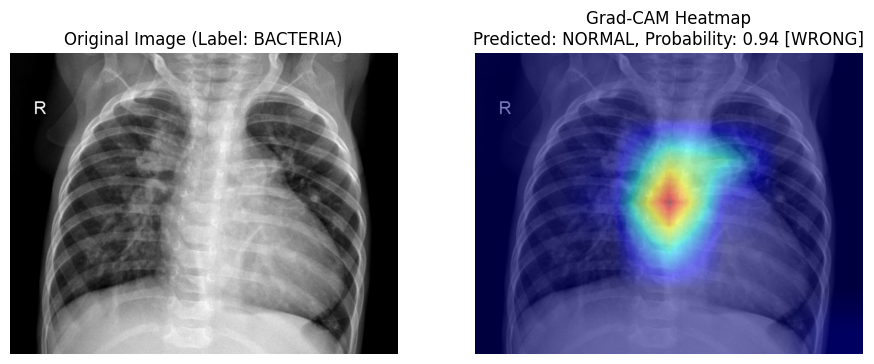

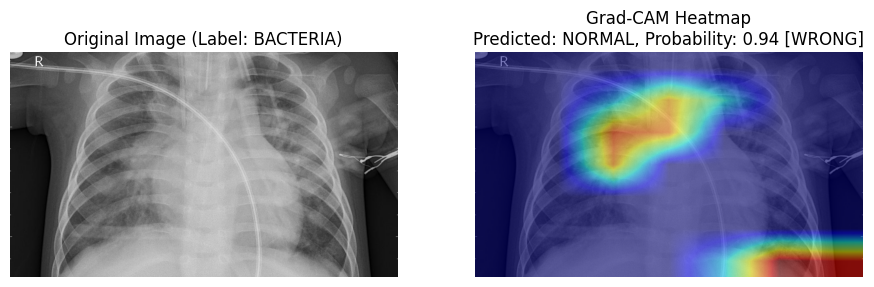

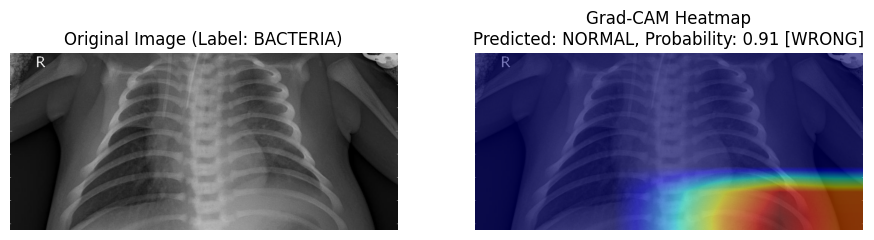

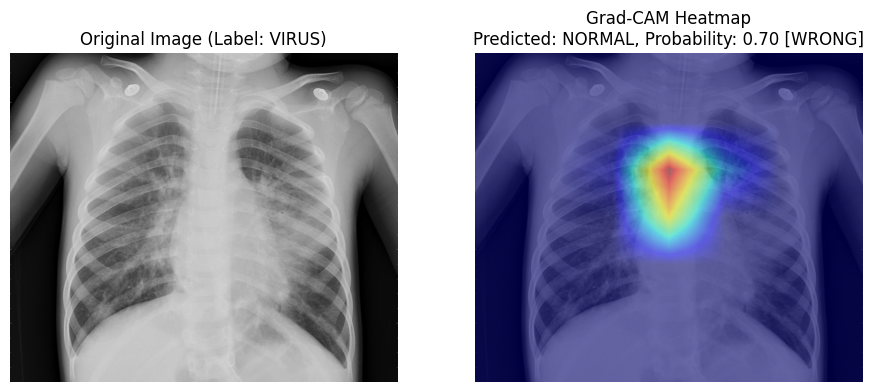

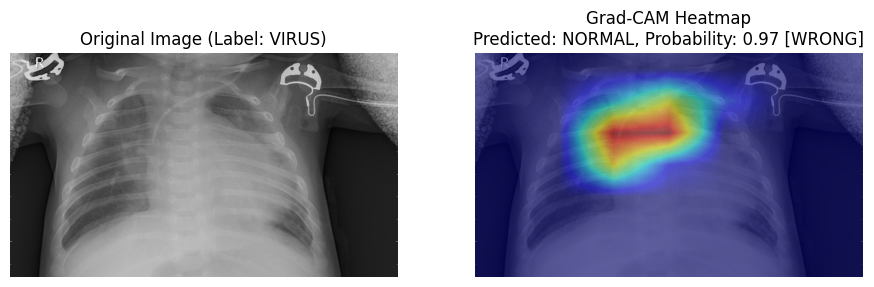

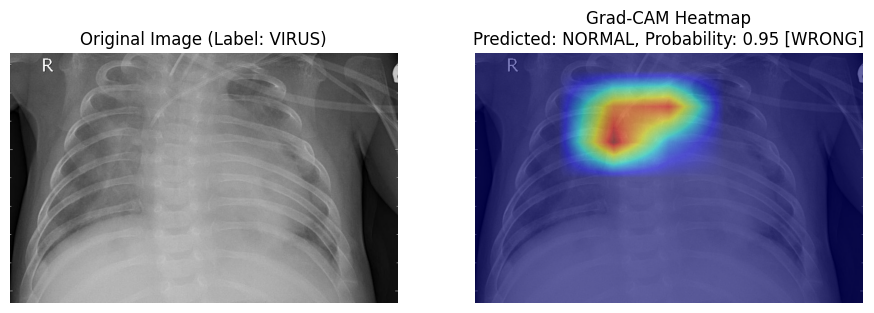

In [13]:
# Usage for multiclass classification
analyze_model(model_multi, transform, 'multi')

### Revert directory split

In [14]:
def revert_split(base_dir):
    """
    Reverts the split operation by moving all files from 'virus' and 'bacteria' directories
    back to the original 'PNEUMONIA' directory.
    
    Args:
        base_dir (str): Path to the directory containing 'VIRUS' and 'BACTERIA' subdirectories.
    """
    virus_dir = os.path.join(base_dir, "VIRUS")
    bacteria_dir = os.path.join(base_dir, "BACTERIA")

    # Ensure the base directory exists
    if not os.path.exists(base_dir):
        print(f"[ERROR] Base directory {base_dir} does not exist.")
        return

    # Move files from subdirectories back to the base directory
    for sub_dir in [virus_dir, bacteria_dir]:
        if os.path.exists(sub_dir):
            for filename in os.listdir(sub_dir):
                file_path = os.path.join(sub_dir, filename)
                if os.path.isfile(file_path):  # Skip directories
                    shutil.move(file_path, os.path.join(base_dir, filename))

            # Optionally remove the now-empty directory
            os.rmdir(sub_dir)

    print(f"Files have been successfully reverted to '{base_dir}'.")

# Example usage
base_dir = r"..\data/test/PNEUMONIA"
revert_split(base_dir)


Files have been successfully reverted to '..\data/test/PNEUMONIA'.
